<h1><strong>Weather Prediction Experiment</strong></h1>
<p>In this experiment, we will use the first time step to predict the entire trajectory.</p>

In [ ]:
import torch
import os
import h5py
import preprocess
import numpy as np
import matplotlib.pyplot as plt
from utils import SequenceDataset, plot_sample
from tqdm import tqdm
from torch.utils.data import DataLoader
from torch import nn, optim
from pathlib import Path
# Import the necessary classes
from score import ScoreUNet
from score import VPSDE
from score import GaussianScore
import importlib
import score
importlib.reload(score)

<h2>Load Model</h2>

In [ ]:
checkpoint_path = "slurm/checkpoints/attention_config_spatial_T2m_U10m_2000_2014/attention_config_spatial_T2m_U10m_2000_2014_310.pth"

In [ ]:
import importlib
import score
importlib.reload(score)
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

PATH_DATA = Path('./data/processed')
# Load mask
with h5py.File(PATH_DATA / "mask.h5", "r") as f:
    mask = torch.tensor(f["dataset"][:], dtype=torch.float32, device=device).unsqueeze(0)
    mask_cpu = mask.detach().clone().cpu()
if torch.isnan(mask).any():
    raise ValueError("Mask contains NaN values!")
window = 12
# Load dataset to get dimensions
testset = SequenceDataset(PATH_DATA / "test.h5", window=window, flatten=True)
channels, y_dim, x_dim = testset[0][0].shape
print(f"Channels : {channels}")

TRAIN_CONFIG = {
    "epochs": 10000,
    "batch_size": 5,
    "learning_rate": 2e-4,
    "weight_decay": 1e-4,
    "scheduler": "cosine",
    "embedding": 64,
    "activation": "SiLU",
    "eta": 5e-3,
}
MODEL_CONFIG = { 'hidden_channels' : [64, 128,128,256],
'attention_levels' : [2],
'hidden_blocks' : [2,3,3,3],
'spatial' : 2,
'channels' : channels,
'context' : 4,
'embedding' : 64 }

In [ ]:
batch_size = TRAIN_CONFIG['batch_size']
testloader = DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=1, persistent_workers=True)
# Initialize ScoreUNet and VPSDE
score_unet = ScoreUNet(**MODEL_CONFIG).to(device)
vpsde = VPSDE(score_unet, shape=(channels, y_dim, x_dim), eta = TRAIN_CONFIG["eta"]).to(device)
# Load checkpoint
checkpoint = torch.load(checkpoint_path, map_location=device)
vpsde.load_state_dict(checkpoint['model_state_dict'])
print(f"Model restored from {checkpoint_path}, trained until epoch {checkpoint['epoch']}")

/tmp/ipykernel_735348/3784321478.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


Model restored from slurm/checkpoints/attention_config_spatial_T2m_U10m_2000_2014/attention_config_spatial_T2m_U10m_2000_2014_310.pth, trained until epoch 310


<h2>Define First Time Step Operator A(x)</h2>

In [ ]:
def first_timestep(batch, mask):
    """Extract only the first timestep from the batch and replicate it across all timesteps."""
    if batch.ndim == 4:
        batch = batch.unsqueeze(0)
    S, B, C, H, W = batch.shape
    num_variables = 2  # T2m and U10m
    window = C // num_variables
    batch_reshaped = batch.view(S, B, window, num_variables, H, W)
    first_step = batch_reshaped[:, :, 0, :, :, :]
    expanded = first_step.unsqueeze(2).expand(-1, -1, window, -1, -1, -1)
    return expanded.reshape(S, B, C, H, W) * mask

def A(x):
    return first_timestep(x, mask)

torch.Size([10, 24, 64, 64])
T2m  Mean : 25.12944793701172, Var: 2.412216901779175
U10m  Mean : 2.6095316410064697, Var: 1.0341864824295044
T2m  Mean : 21.935226440429688, Var: 1.7260818481445312
U10m  Mean : 3.444439649581909, Var: 1.2624255418777466
T2m  Mean : 7.9284539222717285, Var: 1.8791074752807617
U10m  Mean : 6.90432071685791, Var: 2.123634099960327
T2m  Mean : 7.712973594665527, Var: 1.850621223449707
U10m  Mean : 6.64890193939209, Var: 2.1381466388702393


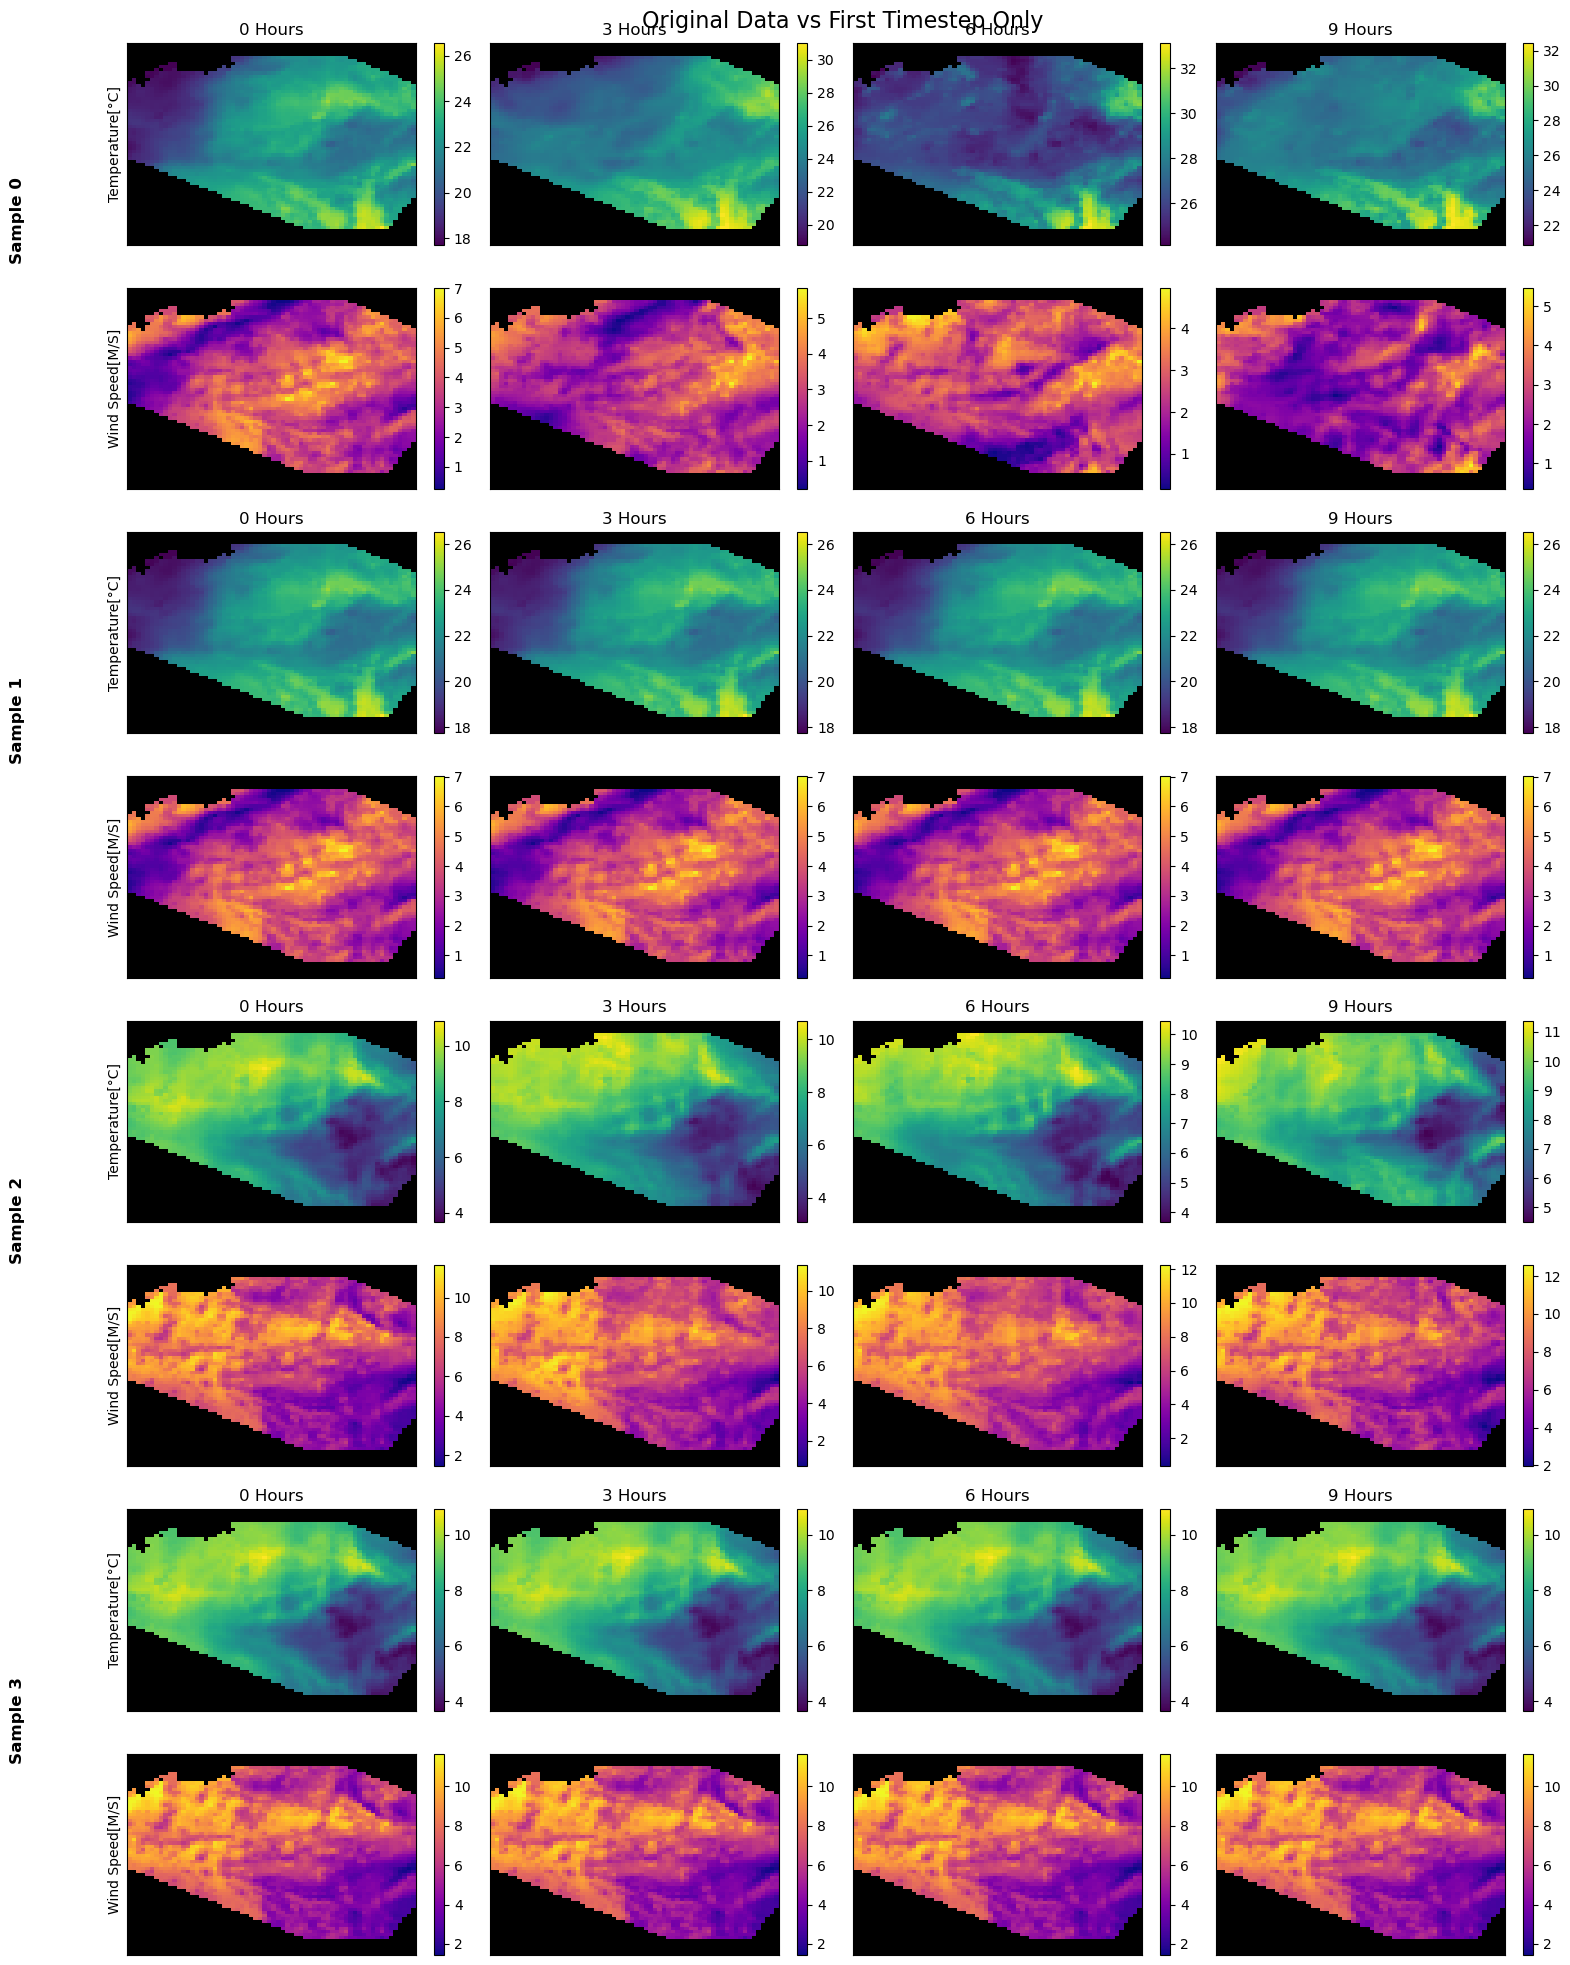

In [ ]:

batch, dic = next(iter(testloader))
batch = batch.to(device)
first_step_data = A(batch)

new_tensor = torch.stack((batch.cpu(), first_step_data.cpu()), dim=1).flatten(0,1).cpu()
path_unnorm = PATH_DATA/ "train.h5"
info  = {'var_index': ['T2m', 'U10m'], 'channels' : 2, 'window' : 12}
fig = plot_sample(new_tensor, info, mask_cpu, samples=4, step=3, unnormalize=True, path_unnorm=path_unnorm)
plt.suptitle("Original Data vs First Timestep Only", fontsize=16)
plt.tight_layout()

<h2>Prediction Experiment</h2>

In [ ]:
x_star, c_star = next(iter(testloader))
x_star = x_star.to(device)
c_star = c_star['context'].to(device)


y_star = torch.normal(A(x_star), 1e-2)*mask  

info  = {'var_index': ['T2m', 'U10m'], 'channels' : 2, 'window' : 12}
comparison = torch.stack((x_star.cpu(), y_star.cpu()), dim=1).flatten(0,1).cpu()
fig = plot_sample(comparison, info, mask_cpu, samples=2, step=2, unnormalize=True, path_unnorm=path_unnorm)
plt.suptitle("Ground Truth vs First Timestep Input", fontsize=16)
plt.tight_layout()

torch.Size([5, 24, 64, 64])


ValueError: not enough values to unpack (expected 5, got 4)

In [ ]:
import score
importlib.reload(score)
print('?')
x_star, c_star = next(iter(testloader))
x_star, c_star = x_star[0].unsqueeze(0), c_star['context'][0].unsqueeze(0)
print(x_star.shape, c_star.shape)
x_star = x_star.to(device)
c_star = c_star.to(device)
y_star = torch.normal(A(x_star), 1e-2)*mask  
print(y_star.shape)
sde = VPSDE(score.DPSGaussianScore(y_star, mask, A=A, sde=vpsde, zeta=5.0), shape=x_star.shape).to(device)



?
torch.Size([1, 24, 64, 64]) torch.Size([1, 4, 64, 64])
torch.Size([1, 1, 24, 64, 64])
torch.Size([1, 1, 24, 64, 64])


In [ ]:

x = sde.sample(mask, shape=(1,), c=c_star, steps=256, corrections=8, tau=0.5).cpu()

hello


  0%|                                                           | 0/256 [00:00<?, ?it/s]

torch.Size([1, 1, 24, 64, 64])
torch.Size([1, 1, 24, 64, 64])
torch.Size([1, 1, 24, 64, 64])
torch.Size([1, 1, 24, 64, 64])
torch.Size([1, 1, 24, 64, 64])


  0%|▏                                                  | 1/256 [00:00<01:40,  2.53it/s]

torch.Size([1, 1, 24, 64, 64])
torch.Size([1, 1, 24, 64, 64])
torch.Size([1, 1, 24, 64, 64])
torch.Size([1, 1, 24, 64, 64])
torch.Size([1, 1, 24, 64, 64])
torch.Size([1, 1, 24, 64, 64])
torch.Size([1, 1, 24, 64, 64])
torch.Size([1, 1, 24, 64, 64])
torch.Size([1, 1, 24, 64, 64])
torch.Size([1, 1, 24, 64, 64])


  1%|▍                                                  | 2/256 [00:00<01:37,  2.59it/s]

torch.Size([1, 1, 24, 64, 64])
torch.Size([1, 1, 24, 64, 64])
torch.Size([1, 1, 24, 64, 64])
torch.Size([1, 1, 24, 64, 64])
torch.Size([1, 1, 24, 64, 64])
torch.Size([1, 1, 24, 64, 64])
torch.Size([1, 1, 24, 64, 64])
torch.Size([1, 1, 24, 64, 64])
torch.Size([1, 1, 24, 64, 64])
torch.Size([1, 1, 24, 64, 64])
torch.Size([1, 1, 24, 64, 64])

  1%|▌                                                  | 3/256 [00:01<01:36,  2.63it/s]


torch.Size([1, 1, 24, 64, 64])
torch.Size([1, 1, 24, 64, 64])
torch.Size([1, 1, 24, 64, 64])
torch.Size([1, 1, 24, 64, 64])
torch.Size([1, 1, 24, 64, 64])
torch.Size([1, 1, 24, 64, 64])
torch.Size([1, 1, 24, 64, 64])
torch.Size([1, 1, 24, 64, 64])
torch.Size([1, 1, 24, 64, 64])


  2%|▊                                                  | 4/256 [00:01<01:34,  2.65it/s]

torch.Size([1, 1, 24, 64, 64])
torch.Size([1, 1, 24, 64, 64])
torch.Size([1, 1, 24, 64, 64])
torch.Size([1, 1, 24, 64, 64])
torch.Size([1, 1, 24, 64, 64])


  2%|▉                                                  | 5/256 [00:01<01:34,  2.64it/s]

torch.Size([1, 1, 24, 64, 64])
torch.Size([1, 1, 24, 64, 64])
torch.Size([1, 1, 24, 64, 64])
torch.Size([1, 1, 24, 64, 64])
torch.Size([1, 1, 24, 64, 64])
torch.Size([1, 1, 24, 64, 64])
torch.Size([1, 1, 24, 64, 64])
torch.Size([1, 1, 24, 64, 64])
torch.Size([1, 1, 24, 64, 64])
torch.Size([1, 1, 24, 64, 64])
torch.Size([1, 1, 24, 64, 64])


  2%|█▏                                                 | 6/256 [00:02<01:36,  2.59it/s]

torch.Size([1, 1, 24, 64, 64])
torch.Size([1, 1, 24, 64, 64])
torch.Size([1, 1, 24, 64, 64])
torch.Size([1, 1, 24, 64, 64])


KeyboardInterrupt: 

hello


100%|███████████████████████████████████████████████████| 64/64 [00:09<00:00,  6.57it/s]


torch.Size([25, 24, 64, 64])
T2m  Mean : 9.063899993896484, Var: 3.5009100437164307
U10m  Mean : 2.163181781768799, Var: 1.2315285205841064
T2m  Mean : 2.8002474308013916, Var: 1.5957682132720947
U10m  Mean : 2.0712790489196777, Var: 0.5848006010055542
T2m  Mean : 18.74083137512207, Var: 4.07780647277832
U10m  Mean : 1.6543811559677124, Var: 1.0984317064285278
T2m  Mean : -0.19311688840389252, Var: 1.9767310619354248
U10m  Mean : 1.7850455045700073, Var: 1.102246642112732
T2m  Mean : 1.498777985572815, Var: 2.294717788696289
U10m  Mean : 1.579000473022461, Var: 0.9264318346977234
T2m  Mean : 5.3202805519104, Var: 1.2545818090438843
U10m  Mean : 7.071603775024414, Var: 1.3227845430374146
T2m  Mean : 6.0328569412231445, Var: 1.5005466938018799
U10m  Mean : 7.400227069854736, Var: 1.3332173824310303
T2m  Mean : 4.6137189865112305, Var: 1.946824073791504
U10m  Mean : 17.74017906188965, Var: 7.69135856628418
T2m  Mean : 58.49766540527344, Var: 6.138317584991455
U10m  Mean : 14.3473129272460

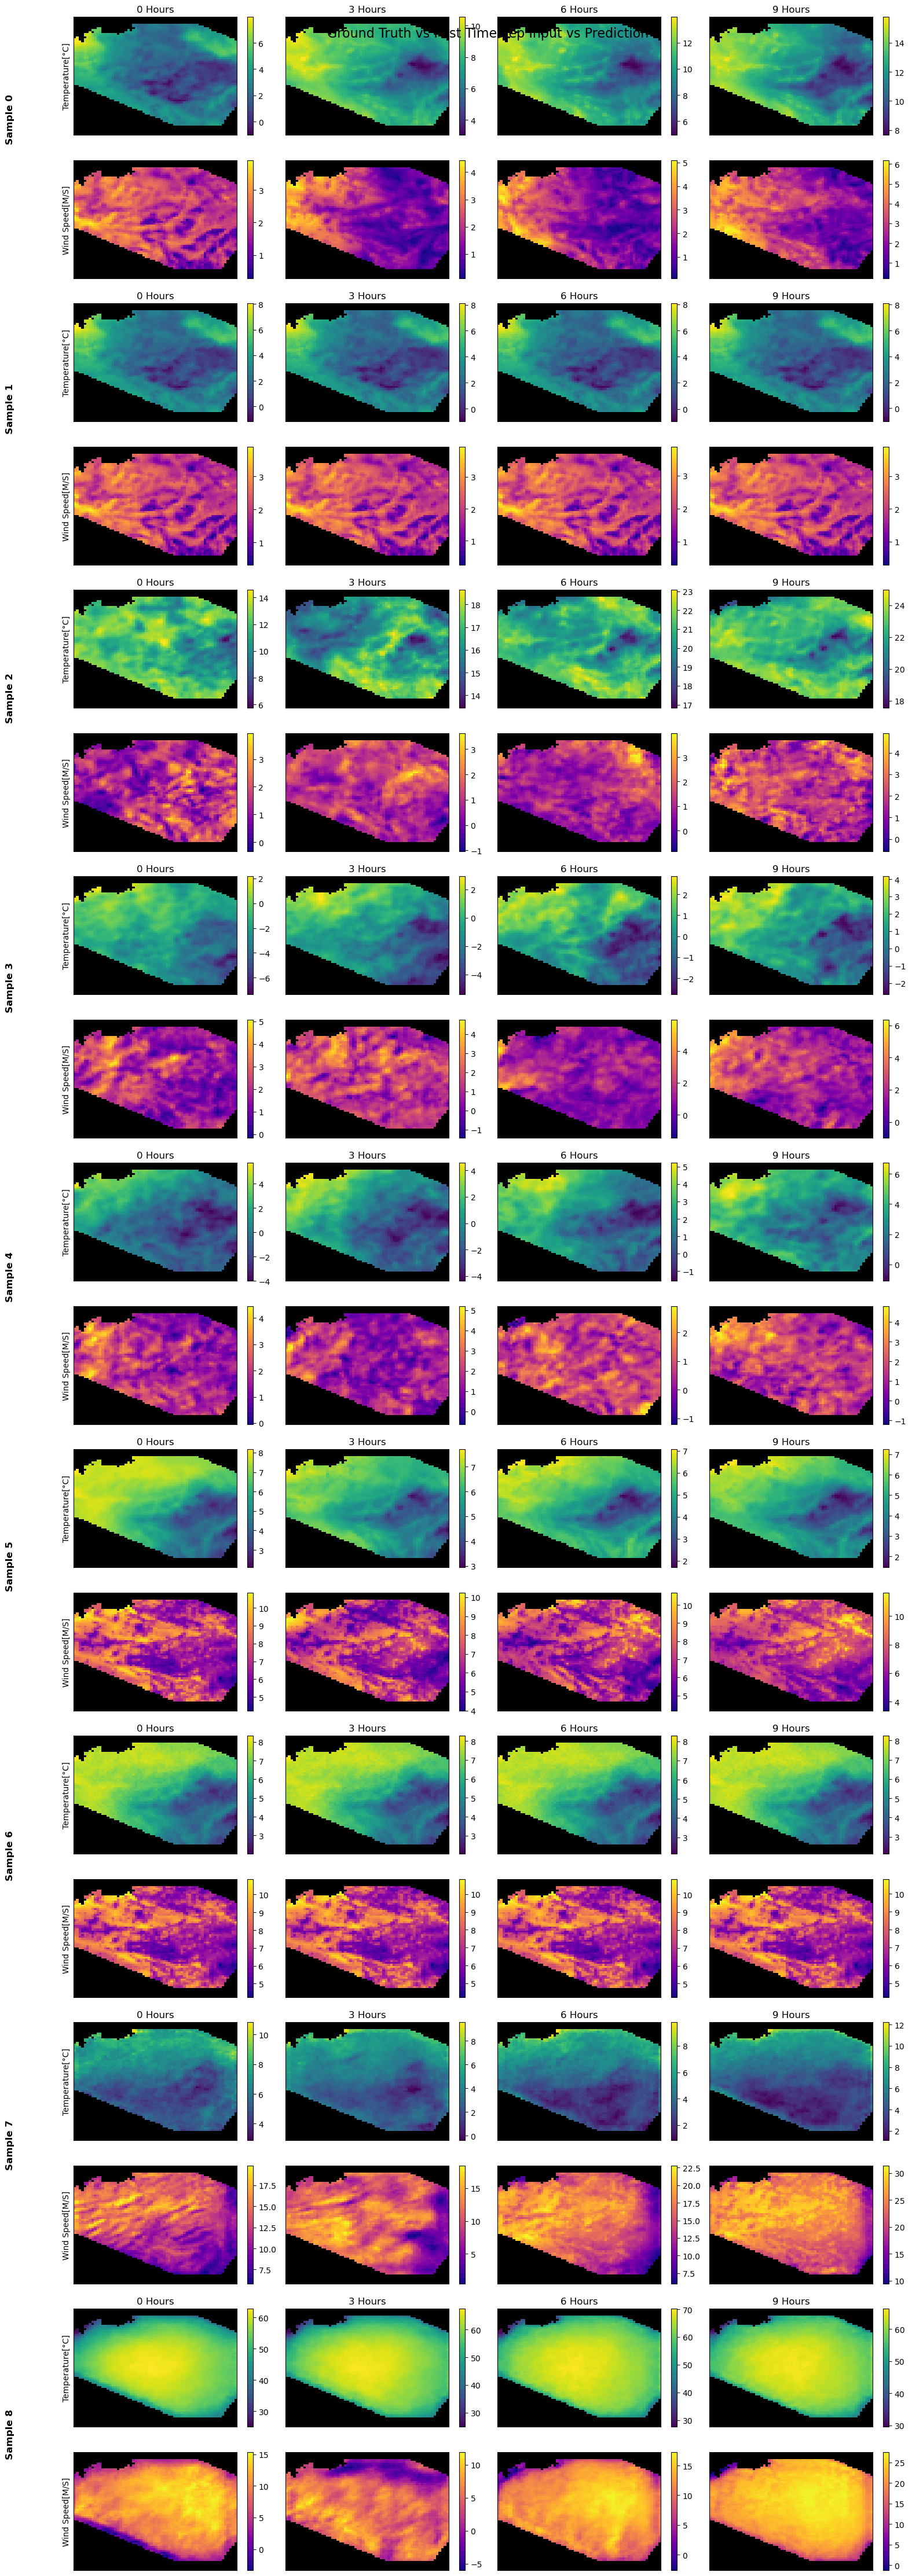

In [ ]:

num_samples = 3
x_preds = sde.sample(mask, shape=(num_samples,), c=c_star, steps=64, corrections=2, tau=0.5).cpu()
all_tensors = [x_star.detach().cpu(), y_star.detach().cpu()] + [x_preds[i] for i in range(num_samples)]
new_tensor = torch.stack(all_tensors, dim=1).flatten(0,1).cpu()

path_unnorm = PATH_DATA/ "train.h5"
info  = {'var_index': ['T2m', 'U10m'], 'channels' : 2, 'window' : 12}
fig = plot_sample(new_tensor, info, mask_cpu, samples=9, step=3, unnormalize=True, path_unnorm=path_unnorm)
plt.suptitle("Ground Truth vs First Timestep Input vs Prediction", fontsize=16)
plt.tight_layout()